# Notebook 1: Describing network data
#### Econometric Methods for Social Spillovers and Networks
#### University of St. Gallen, September 28th to October 6th, 2020
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
This is the first of a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given (virtually!) at the St. Gallen University from September 28th and October 6th, 2020. The scripts below were written for Python 3.6. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.

#### Code citation    
Graham, Bryan S. (2020). "Notebook 1: Describing network data: St. Gallen University Econometric Methods for Social Spillovers and Networks Course Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 20 December 2020)

I begin by importing several key packages. The _numpy_ and _scipy_ libraries include a core set of scientific computing tools. The _pandas_ package is useful for data organization and analysis, while _matplotlib_ is Python's basic plotting add-on. Finally the _networkx_ package includes functionality for analysis, and also visualizing, network data.

In [31]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Main scientific computing modules
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib 
import matplotlib.pyplot as plt

# networkx module for the analysis of network data
import networkx as nx

The following code snippet should be edited to point to wherever you have saved the instructional datasets used in the book and/or want to store the figures generated in this notebook. The "data" string points to where the data files are saved. The "graphics" string points to where the figures generated below are saved.
<br>
<br>
Since these notesbooks are revisions of those intitially prepared for the 2018 version of the course at St. Gallen University you can find the instructural datasets in the GitHub folder for that course.

In [32]:
# Directory where graphics files will be saved
data =     '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/2018/Data/'
graphics = '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/2018/Graphics/'

To introduce some basic ideas of network analysis as well as associated Python functionality we will use the Nyakatoke risk sharing network data collected by Joachim de Weerdt. The de Weerdt (2004) paper in the course syllabus describes the dataset in some detail. There are four different files, we will mostly use the _Nyakatoke individual.dta_ and _Nyakatoke dyadic.dta_ files. The files are available for download from https://www.uantwerpen.be/en/staff/joachim-deweerdt/.

In [33]:
Nyakatoke_ind = pd.read_stata(data+"Nyakatoke individual.dta")
Nyakatoke_dyad = pd.read_stata(data+"Nyakatoke dyadic.dta")
Nyakatoke_hh = pd.read_stata(data+"Nyakatoke household.dta")
Nyakatoke_dir = pd.read_stata(data+"Nyakatoke directed.dta")

Here are the first few lines of the _Nyakatoke dyadic.dta_ file. Each row corresponds to a dyad -- that is a pair of households, whether connected or not.

In [34]:
Nyakatoke_dyad.head()

,hh1,hh2,links,kinship,distance,land1,land2,livestock1,livestock2,clan1,clan2,religion1,religion2
0,1.0,2.0,no link,other blood relation,91.199997,2.999796,1.791863,865800.0,126400.0,21.0,6.0,Catholic,Catholic
1,1.0,3.0,no link,no blood relation,69.599998,2.999796,0.396078,865800.0,35000.0,21.0,21.0,Catholic,Catholic
2,1.0,4.0,unilateral link,no blood relation,199.199997,2.999796,0.832353,865800.0,24600.0,21.0,23.0,Catholic,Catholic
3,1.0,5.0,no link,no blood relation,252.000000,2.999796,0.483366,865800.0,52600.0,21.0,23.0,Catholic,Catholic
4,1.0,6.0,no link,no blood relation,213.600006,2.999796,0.437647,865800.0,8200.0,21.0,23.0,Catholic,Catholic


In order to merge the individual and dyadic data we need to perform a few string comprehensions in order to link records. We can then aggregate the individual data up to the household level and perform a many-to-one merge of the dyadic with the household data (since the same household will belong to multiple dyads).

In [35]:
Nyakatoke_ind.dropna(subset=['hhind'], inplace = True)               # Drop rows with missing identification number
Nyakatoke_ind['hh1']=Nyakatoke_ind['hhind'].apply(str).str[2:5]      # Create household ID number
Nyakatoke_ind['iid']=Nyakatoke_ind['hhind'].apply(str).str[5:7]      # Create individual ID number

# Find age of household head
Nyakatoke_ind['head_age'] = None
Nyakatoke_ind.loc[Nyakatoke_ind['iid']=='01', 'head_age'] = Nyakatoke_ind['age']

# Find sex of household head
gender_dict = {'male' : 1, 'female' : 0}
Nyakatoke_ind['head_sex'] = np.nan
Nyakatoke_ind.loc[Nyakatoke_ind['iid']=='01', 'head_sex'] = Nyakatoke_ind['sex'].map(gender_dict)

# Create completed primary school dummy variable
Nyakatoke_ind['primary'] = ((Nyakatoke_ind['education'] == 'finished primary') | (Nyakatoke_ind['education'] == 'secondary'))*1

In [36]:
# Set of househoulds represented in individual data
hh_set_ind = set(Nyakatoke_ind['hh1'].unique())
print(str(len(hh_set_ind)) + ' households appear in individual-level data file')

121 households appear in individual-level data file


In [37]:
Nyakatoke_ind

,hhind,age,sex,education,act_offfarm,act_casual,act_trade,act_crop,act_livest,act_assets,act_process,hh1,iid,head_age,head_sex,primary
0,1000101.0,75.0,male,started primary,0.0,0.0,0.0,1.0,1.0,0.0,0.0,001,01,75,1.0,0
1,1000102.0,56.0,female,no education,0.0,0.0,0.0,1.0,1.0,0.0,0.0,001,02,None,NaN,0
2,1000103.0,78.0,female,no education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001,03,None,NaN,0
3,1000201.0,30.0,male,finished primary,0.0,1.0,0.0,1.0,1.0,0.0,1.0,002,01,30,1.0,1
4,1000202.0,27.0,female,finished primary,0.0,1.0,0.0,1.0,0.0,0.0,0.0,002,02,None,NaN,1
5,1000301.0,48.0,female,started primary,0.0,0.0,0.0,1.0,0.0,0.0,0.0,003,01,48,0.0,0
6,1000302.0,24.0,male,finished primary,0.0,0.0,0.0,1.0,0.0,0.0,0.0,003,02,None,NaN,1
7,1000303.0,22.0,female,secondary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,003,03,None,NaN,1
8,1000401.0,80.0,male,started primary,0.0,0.0,0.0,1.0,1.0,0.0,0.0,004,01,80,1.0,0
9,1000402.0,45.0,female,no education,0.0,0.0,0.0,1.0,0.0,0.0,0.0,004,02,None,NaN,0


In [38]:
# Create household-level dataset with age, sex and primary completion infomation
hh_var = Nyakatoke_ind[['head_age','head_sex','primary','hh1']].groupby('hh1').max()
hh_var['num_respondents'] = Nyakatoke_ind[['iid','hh1']].groupby('hh1').count()['iid']

hh_var.reset_index(inplace=True)
print(hh_var.describe())

# Set of househoulds represented in household-level attribute data file
hh_set_hh_var = set(hh_var['hh1'].unique())
print("")
print(str(len(hh_set_hh_var)) + ' households appear in household-level attribute data file')

         head_age    head_sex     primary  num_respondents
count  118.000000  118.000000  121.000000       121.000000
mean    44.898305    0.788136    0.760331         2.528926
std     15.931150    0.410372    0.428657         1.323344
min     15.000000    0.000000    0.000000         1.000000
25%     33.000000    1.000000    1.000000         2.000000
50%     42.000000    1.000000    1.000000         2.000000
75%     56.750000    1.000000    1.000000         3.000000
max     89.000000    1.000000    1.000000         9.000000

121 households appear in household-level attribute data file


This next block of code creates the household economic activity variable used by De Weerdt (2004, _Insurance Against Poverty_)

In [39]:
# Total number of activities engaged in by each individual 
Nyakatoke_ind['act_total'] = Nyakatoke_ind['act_offfarm'] + Nyakatoke_ind['act_casual'] + Nyakatoke_ind['act_trade'] \
                           + Nyakatoke_ind['act_crop']    + Nyakatoke_ind['act_livest'] + Nyakatoke_ind['act_assets'] \
                           + Nyakatoke_ind['act_process']

# Compute totals by category for each household        
hh_act = Nyakatoke_ind[['act_offfarm', 'act_casual', 'act_trade', 'act_crop', \
                        'act_livest', 'act_assets', 'act_process', 'act_total', 'hh1']].groupby('hh1').sum()

# Covert total counts into percentages as in De Weerdt (2004)
for activity in ['offfarm', 'casual', 'trade', 'crop', 'livest', 'assets', 'process']:
    hh_act['prc_' + activity] = (hh_act['act_'+ activity] / hh_act['act_total'])*100
    hh_act['prc_' + activity][hh_act['act_total']==0] = 0 # Avoid divide by zero error for households with no activity
    print(hh_act['act_'+ activity].value_counts())
    hh_act.drop('act_'+ activity, axis=1, inplace=True)
    
    
hh_act.drop('act_total', axis=1, inplace=True)
hh_act.reset_index(inplace=True)
print(hh_act.describe())

# Set of househoulds represented in household-level activity data file
hh_set_hh_act = set(hh_act['hh1'].unique())
print("")
print(str(len(hh_set_hh_act)) + ' households appear in household-level activity data file')

0.0    80
1.0    37
2.0     3
3.0     1
Name: act_offfarm, dtype: int64
0.0    63
1.0    43
2.0    14
3.0     1
Name: act_casual, dtype: int64
0.0    80
1.0    34
2.0     7
Name: act_trade, dtype: int64
1.0    70
2.0    31
0.0    15
3.0     5
Name: act_crop, dtype: int64
0.0    91
1.0    28
2.0     2
Name: act_livest, dtype: int64
0.0    114
1.0      7
Name: act_assets, dtype: int64
0.0    82
1.0    25
2.0    12
3.0     2
Name: act_process, dtype: int64
       prc_offfarm  prc_casual   prc_trade    prc_crop  prc_livest  \
count   121.000000  121.000000  121.000000  121.000000  121.000000   
mean      9.737308   18.432704   10.992719   37.748918    6.856553   
std      15.516507   22.586988   19.164951   24.072771   13.466583   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    0.000000   25.000000    0.000000   
50%       0.000000    0.000000    0.000000   33.333333    0.000000   
75%      20.000000   33.333333   20.000000   50.0000

In [40]:
# Now work with the dyadic dataframe
# Convert hh1 to string and add leading zeros (to matched with hh_act and hh_var dataframes created above)
Nyakatoke_dyad.loc[:,'hh1'] = Nyakatoke_dyad['hh1'].apply(str).str.zfill(5)

# remove decimal and digits to its right
Nyakatoke_dyad.loc[:,'hh1'] = Nyakatoke_dyad['hh1'].apply(str).str[0:3]

# Repeat conversions for hh2
Nyakatoke_dyad.loc[:,'hh2'] = Nyakatoke_dyad['hh2'].apply(str).str.zfill(5)
Nyakatoke_dyad.loc[:,'hh2'] = Nyakatoke_dyad['hh2'].apply(str).str[0:3]

In [41]:
# Merge household head age, sex and primary completion information into dyadic dataframe
# First for household 1 in the dyad
Nyakatoke_dyad = Nyakatoke_dyad.merge(hh_var, on = 'hh1', how = 'left', copy = False)
Nyakatoke_dyad.rename(columns={'head_age' : 'head_age1', 'head_sex' : 'head_sex1', 'primary' : 'primary1', \
                               'num_respondents' : 'num_respondents1'}, inplace=True)

# Then for household 2 in the dyad
Nyakatoke_dyad = Nyakatoke_dyad.merge(hh_var, left_on='hh2', right_on = 'hh1', how = 'left', copy = False)

# NOTE: Last merge creates two instances of hh1 due to how the merge above was done. Drop the second instance and
#       rename the first
Nyakatoke_dyad.drop('hh1_y', axis=1, inplace=True)
Nyakatoke_dyad.rename(columns={'hh1_x' : 'hh1'}, inplace=True)

Nyakatoke_dyad.rename(columns={'head_age' : 'head_age2', 'head_sex' : 'head_sex2', 'primary' : 'primary2', \
                               'num_respondents' : 'num_respondents2'}, inplace=True)

In [42]:
# Merge household economic activity information into dyadic dataframe
# First for household 1 in the dyad
Nyakatoke_dyad = Nyakatoke_dyad.merge(hh_act, on = 'hh1', how = 'left', copy = False)

for activity in ['offfarm', 'casual', 'trade', 'crop', 'livest', 'assets', 'process']:
    Nyakatoke_dyad.rename(columns={'prc_' + activity : 'prc_' + activity + '1'}, inplace=True)

# Then for household 2 in the dyad
Nyakatoke_dyad = Nyakatoke_dyad.merge(hh_act, left_on='hh2', right_on = 'hh1', how = 'left', copy = False)

# NOTE: Last merge creates two instances of hh1 due to how the merge above was done. Drop the second instance and
#       rename the first
Nyakatoke_dyad.drop('hh1_y', axis=1, inplace=True)
Nyakatoke_dyad.rename(columns={'hh1_x' : 'hh1'}, inplace=True)

for activity in ['offfarm', 'casual', 'trade', 'crop', 'livest', 'assets', 'process']:
    Nyakatoke_dyad.rename(columns={'prc_' + activity : 'prc_' + activity + '2'}, inplace=True)

It is useful to have a household level measure of wealth. Here I use the conversion of land and livestock wealth into Tanzanian Shillings proposed by Comola and Fafchamps (2014 _Economic Journal_).

In [43]:
# Comola and Fafchamps (2014) wealth formula
Nyakatoke_dyad['wealth1'] = (300000*Nyakatoke_dyad['land1'] + Nyakatoke_dyad['livestock1'])/100000
Nyakatoke_dyad['wealth2'] = (300000*Nyakatoke_dyad['land2'] + Nyakatoke_dyad['livestock2'])/100000

In [44]:
hh_set = set(Nyakatoke_dyad['hh1'].unique()) | set(Nyakatoke_dyad['hh2'].unique()) # Set of all households
N = len(hh_set)                                            # Number of households
n = N * (N - 1) //2                                        # Number of dyads

print("")
print(str(len(hh_set)) + ' households appear in dyad-level data file')


119 households appear in dyad-level data file


In [45]:
# Convert hh1 to string and add leading zeros (to matched with hh_act and hh_var dataframes created above)
Nyakatoke_hh.loc[:,'hh'] = Nyakatoke_hh['hh'].apply(str).str.zfill(5)

# remove decimal and digits to its right
Nyakatoke_hh.loc[:,'hh'] = Nyakatoke_hh['hh'].apply(str).str[0:3]

Calculate household-level clan membership and religion variables

In [46]:
Nyakatoke_hh['clan'] = None
Nyakatoke_hh['religion'] = None

for hh in hh_set:
    Nyakatoke_hh.loc[Nyakatoke_hh['hh'] == hh, 'clan'] = \
        Nyakatoke_dyad.loc[Nyakatoke_dyad['hh1'] == hh, 'clan1'].\
        append(Nyakatoke_dyad.loc[Nyakatoke_dyad['hh2'] == hh, 'clan2'], ignore_index=True).unique()
    Nyakatoke_hh.loc[Nyakatoke_hh['hh'] == hh, 'religion'] = \
        Nyakatoke_dyad.loc[Nyakatoke_dyad['hh1'] == hh, 'religion1'].\
        append(Nyakatoke_dyad.loc[Nyakatoke_dyad['hh2'] == hh, 'religion2'], ignore_index=True).unique()    
    
print("")
print("Membership counts for clans: across households")    
print("---------------------------------------------------")
print(Nyakatoke_hh['clan'].value_counts())

print("")
print("Membership counts for religions: across households")    
print("---------------------------------------------------")
print(Nyakatoke_hh['religion'].value_counts())



Membership counts for clans: across households
---------------------------------------------------
21.0    23
16.0    20
4.0     12
6.0     10
19.0    10
23.0     8
13.0     6
18.0     4
22.0     3
2.0      3
7.0      2
20.0     2
15.0     2
14.0     2
24.0     2
3.0      1
5.0      1
25.0     1
8.0      1
9.0      1
10.0     1
11.0     1
12.0     1
17.0     1
1.0      1
Name: clan, dtype: int64

Membership counts for religions: across households
---------------------------------------------------
Catholic    49
Lutheran    46
Muslim      24
Name: religion, dtype: int64


## Creating a graph object using _networkx_
The _networkx_ package provides functionality for defining, exploring and, to a lesser extent, visualizing network data. The next snippet of code defines a graph object using the Nyakatoke data. First I add each household in Nyakatoke to the graph object as a node, second I use *Nyakatoke\_dyad* dataframe to add edges or links where needed. Specifically, I use a Python list comprehension to quickly iterate through all dyads in the dataframe and add a link to the graph object as appropriate.

In [47]:
# create networkx graph object
G=nx.Graph()

# add households to graph object
hh_list = list(Nyakatoke_dyad['hh1'].unique())
G.add_nodes_from(hh_list)

# create edge list and add to graph 
G.add_edges_from([(row['hh1'], row['hh2']) for index, row in Nyakatoke_dyad.iterrows() if \
                  (row['links']!='no link') ])

# add some household attributes to graph
nx.set_node_attributes(G, dict(zip(hh_var.hh1, hh_var.head_age)), 'age')
nx.set_node_attributes(G, dict(zip(hh_var.hh1, hh_var.primary)), 'education')

The network visualization features of _networkx_ are basic, but sufficient for most purposes likely to arise in economics. In the picture generated below I color each node according to its wealth level. Berkeley Blue nodes correspond to "very poor" households; those with land and livestock wealth below 150,000 Tanzanian Shillings. Those colored California Gold are "poor" (wealth between 150,000 to 300,000 Shillings), Golden Gate colored nodes are "middle" wealth (300,000 to 600,000 Shillings), and those colored Lawrence are "wealthy" (wealth 600,000 Shillings or more).
<br>
<br>
The size of each node is proportional to is _degree_ (i.e., the number of links it has with other nodes).
<br>
<br>
The next few snippets of code add each households wealth category and degree as an attribute to our graph object. I use Python set operations to avoid repeating data since the same household appears in multiple dyads.

In [48]:
# Categorize households into four bins based on total land and livestock wealth
# using the Comola and Fafchamps (2014, Economic Journal) scheme

# Construct dictionary with hh1 as 'key' and wealth as 'items'
hh_wealth = {} 
for index, row in Nyakatoke_dyad.iterrows():
    hh_wealth.setdefault(row['hh1'], []).append(row['wealth1'])
    hh_wealth.setdefault(row['hh2'], []).append(row['wealth2']) 


hh_log_wealth = {}    

for hh in hh_wealth:
    
    # Remove duplicate wealth measures
    hh_wealth[hh] = list(set(hh_wealth[hh]))[0]
    
    # Update log wealth dictionary
    hh_log_wealth.setdefault(hh, int(round(np.log(1+hh_wealth[hh])*1000,0)))
    
    # Catgorize into four groups
    if hh_wealth[hh] < 1.5:
        hh_wealth[hh] = 'very poor'
    elif (hh_wealth[hh] >= 1.5) & (hh_wealth[hh] < 3):
        hh_wealth[hh] = 'poor'
    elif (hh_wealth[hh] >= 3) & (hh_wealth[hh] < 6):
        hh_wealth[hh] = 'middle'
    elif hh_wealth[hh] >= 6:
        hh_wealth[hh] = 'rich'

# Attach wealth categorization to networkx graph        
nx.set_node_attributes(G, hh_wealth, 'wealth')    
nx.set_node_attributes(G, hh_log_wealth, 'log_wealth')  

# put together a color map, one color for a category
# Berkeley Blue: #003262
# California Gold: #FDB515
# Golden Gate: #ED4E33
# Lawrence: #00B0DA
color_map = {'very poor':'#003262', 'poor':'#FDB515', 'middle':'#ED4E33', 'rich':'#00B0DA'} 

# Construct degree attribute
nx.set_node_attributes(G, dict(nx.degree(G)), 'degree')

Now create the figure object and save it as a png file. Note this next code snippet requires _Graphviz_ and _PyGraphviz_ to be install. Graphviz is available for downloand at http://www.graphviz.org/. PyGraphiz may be installed using conda by typing "conda install -c pdrops pygraphviz=1.2" at the command line.

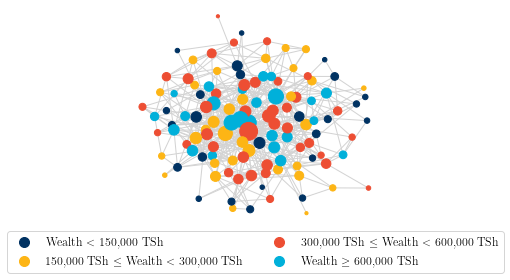

In [49]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from matplotlib.lines import Line2D

# Legend items for node types
very_poor_patch = Line2D([0], [0], color='#003262', marker='o', linestyle='None',\
                         markersize=10)
poor_patch      = Line2D([0], [0], color='#FDB515', marker='o', linestyle='None',\
                         markersize=10)
middle_patch    = Line2D([0], [0], color='#ED4E33', marker='o', linestyle='None',\
                         markersize=10)
rich_patch      = Line2D([0], [0], color='#00B0DA', marker='o', linestyle='None',\
                         markersize=10)

legend_labels = [r'Wealth $<$ 150,000 TSh',\
                 r'150,000 TSh $\leq$ Wealth $<$ 300,000 TSh',\
                 r'300,000 TSh $\leq$ Wealth $<$ 600,000 TSh',\
                 r'Wealth $\geq$  600,000 TSh']

# Use Graphviz to position nodes
# NOTE: need to call graphviz_layout with long name to avoid namespace error bug
node_pos = nx.drawing.nx_agraph.pygraphviz_layout(G,prog='neato')

fig, ax = plt.subplots()
plt.axis('off')  
nx.draw_networkx(G, pos=node_pos, with_labels=False, \
                 node_color = [color_map[G.node[node]['wealth']] for node in G], \
                 node_size = [G.node[node]['degree']*10 for node in G], \
                 edge_color='lightgrey', width=1)
lgd = ax.legend(handles=[very_poor_patch, poor_patch, middle_patch, rich_patch], \
                labels=legend_labels, \
                bbox_to_anchor=(0.5, -0.01), loc='upper center', fontsize=12, ncol=2, numpoints = 1) 

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)

# Remove tick marks and labels
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

# Save figure
plt.tight_layout()
plt.savefig(graphics+'Nyakatoke_Network.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=500)

Frankly the network depiction is not especially informative. The figure does suggest that poorer households are located on the periphery of the network (i.e., have few links), whereas richer households have more links. It does make for a pretty picture however.
<br>
<br>
An important strand of network research takes the so-called _degree sequence_ of a network as its primary object of interest. This is motivated in part, by the fact that many other topological features of a network are fundamental constrained by its degree sequence (c.f, Albert and Barabasi, 2002 _Review of Modern Physics_, Graham, 2015 _Annual Review of Economics_; Wasserman and Faust, 1994, _Social Network Analysis_, Chapter 14).
<br>
<br>
The next snippet of code uses the nx.degree() function to calculate the degree sequence of the Nyakatoke network. And then plots it on a log-log scale.

Complementary Empirical CDF of Nyakatoke Degree Distribution
1     0.983193
2     0.924370
3     0.899160
4     0.806723
5     0.689076
6     0.588235
7     0.478992
8     0.394958
9     0.336134
10    0.252101
11    0.159664
12    0.092437
13    0.075630
14    0.067227
16    0.058824
17    0.050420
20    0.042017
22    0.033613
23    0.025210
24    0.008403
32    0.000000
dtype: float64


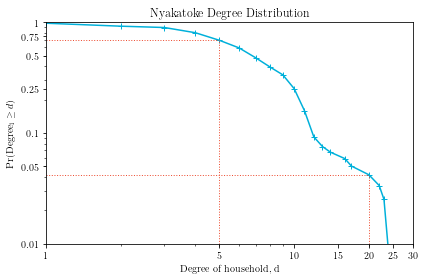

In [50]:
degree_sequence = pd.Series(sorted(dict(nx.degree(G)).values(),reverse=True)) # Degree sequence of network as Pandas series
N               = len(degree_sequence)                                       # Number of households in the network

# Complementary Cumulative Distribution Function for agent degrees
CCDF_degree = 1 - degree_sequence.value_counts().sort_index().cumsum()/N

print("Complementary Empirical CDF of Nyakatoke Degree Distribution")
print(CCDF_degree)

# Plot Nyakatoke Degree Distribution
fig_nyakatoke_degree = plt.figure(figsize=(6,4))
ax = fig_nyakatoke_degree.add_subplot(1,1,1)

plt.loglog(CCDF_degree,'-', marker='+', color='#00B0DA')
plt.title("Nyakatoke Degree Distribution")
plt.xlabel("Degree of household, d")
plt.ylabel(r"$\Pr (\mathrm{Degree_{i}} \geq d)$")

# Set axis limits and tick marks (log scale with tick labels in levels)
plt.ylim([1e-2,1])
plt.xlim([1, 30])

ax.set_yticks([1e-2, 0.05, 0.1 ,0.25, 0.50, 0.75, 1])
ax.set_yticklabels([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1])
ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
ax.set_xticklabels([1, 5, 10, 15, 20, 25, 30])

# Annotate to show large number of low degree households coupled with a few hubs
plt.plot([5, 5], [0.01, CCDF_degree[5]], color='#ED4E33', linestyle=':', linewidth=1)
plt.plot([1, 5], [CCDF_degree[5], CCDF_degree[5]], color='#ED4E33', linestyle=':', linewidth=1)
plt.plot([20, 20], [0.01, CCDF_degree[20]], color='#ED4E33', linestyle=':', linewidth=1)
plt.plot([1, 20], [CCDF_degree[20], CCDF_degree[20]], color='#ED4E33', linestyle=':', linewidth=1)

# Save figure
plt.tight_layout()
plt.savefig(graphics+'Nyakatoke_Degree_Distribution.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=500)

If the degree sequence obeys a power law distribution then the log of the complementary CDF and the log of degree should lie on a straight line. There is not much evidence for power law behavior in the plot above, but it is consistent with a more qualitative feature of many social and economic networks. Specifically, there are many agents with only a small number of links along with a few "hub" agents with many links. In Nyakatoke over a quarter of households have five or fewer risk sharing links, while a little less than five percent of households have twenty or more links.
<br>
<br>
_Networkx_ also includes functionality for calculating basic summary statistics for a network. The next code snipped calculates the density, transitivity, average degree, standard deviation of degree and fraction of nodes in the giant component.

In [51]:
print("Density          : " + "%3.4f" % nx.density(G))                                          # Density           
print("Transitivity     : " + "%3.4f" % nx.transitivity(G))                                     # Transitivity
print("Mean Degree      : " + "%3.4f" % np.mean(degree_sequence))                               # Mean Degree
print("Std. Dev. Degree : " + "%3.4f" % np.std(degree_sequence))                                # Std. of Degree
print("% in Giant Comp. : " + "%2.1f" % (100*len(max(nx.connected_components(G), key=len))/N))  # Giant component

Density          : 0.0698
Transitivity     : 0.1884
Mean Degree      : 8.2353
Std. Dev. Degree : 4.9700
% in Giant Comp. : 100.0


The Nyakatoke network is relatively sparse. Less that 7 percent of all possible edges are present. Transitivity is about three times density. So there are many more closed triangles in the network than one would expect to see in a vanilla random graph with the same density.
<br>
<br>
The _eccentricity()_ function calculates the maximum path length from an agent in the network to all other agents in the network. If the graph is not connected this (maximal) distance will be infinite. Using the counter dictionary subclass we can quickly compute the frequency of different maximal "degrees of separation" in the Nyakatoke network.
<br>
<br>
The maximum path length from one agent to another in the Nyakatoke network is 5. This equals the _diameter_ of the network.

In [52]:
ds = nx.eccentricity(G)

from collections import Counter

for distance, count in Counter(ds.values()).most_common():
    print("Number of agent at most " + str(distance) + " degrees from all other agents is " + str(count))


Number of agent at most 4 degrees from all other agents is 92
Number of agent at most 3 degrees from all other agents is 16
Number of agent at most 5 degrees from all other agents is 11


We can also count the frequency of different shortest path lengths in the network. For each pair agents there is a minimal distance between them. If they are directly connected this distance is one. If they share a friend in common is is two and so on.
<br>
<br>
The *shortest\_path\_length()* function returns a dictionary of dictionaries. There is one dictionary for each household. Each dictionary has households $j=1,..,N$ as keys and shortest path lengths to them as items. The follow snippet of code iterates over these objects and computes the frequency of different shortest path lengths between dyads.

In [53]:
pl = dict(nx.shortest_path_length(G))   # Returns a dictionary of dictionaries
                                        # Each dictionary gives the path length from household i to all households j=1,..,N 

shortest_path_length_counts = {}

for i, path_lengths_for_i in pl.items():
    for j, path_length in path_lengths_for_i.items():
        # If path_length not in dictionary add it as a key and set is item to zero (setdefault method)
        shortest_path_length_counts.setdefault(path_length, 0)
        shortest_path_length_counts[path_length] += 1

for path_length, count in shortest_path_length_counts.items():
    if path_length != 0:
        shortest_path_length_counts[path_length] = count // 2       # Divide by two to avoid double counting
    print(str(shortest_path_length_counts[path_length]) + " pairs of households are " + str(path_length) + " degrees apart")    

119 pairs of households are 0 degrees apart
490 pairs of households are 1 degrees apart
2666 pairs of households are 2 degrees apart
3298 pairs of households are 3 degrees apart
557 pairs of households are 4 degrees apart
10 pairs of households are 5 degrees apart


The Nyakatoke network shares another feature common to many real world social and economic networks. The network is relatively sparse, but simultaneously has small diameter. This goes back to Stanley Milgram's work in the 1960s. Only 490 our of 7021 possible links are present in the network. Density is about 7%. At the same time the shortest path length between any two pairs of households is quite small. While there are only 490 direct ties in the networks, many households share a link/friend in common (2666). The vast majority of dyads are at most three degrees apart.
<br>
<br>
Another commonly reported graph summary is the so called triad census. In the case of directed graphs there are 16 possible wirings of a three agent subgraph. See Wasserman and Faust (1994, Chapters 6 & 14) for background, theorizing and terminology. When the graph is undirected, there are only four possible triad configurations. The following snippet of code creates a figure illustrating each of the four wirings. 

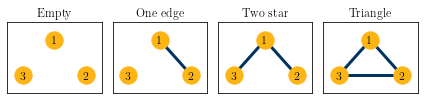

In [54]:
empty=nx.Graph()                        # Empty triad
empty.add_nodes_from([1,2,3])

one_edge=nx.Graph()                     # One edge triad       
one_edge.add_nodes_from(empty)
one_edge.add_edges_from([(1,2)])

two_star=nx.Graph()                     # Two star triad
two_star.add_nodes_from(empty)
two_star.add_edges_from([(1,2),(1,3)])

triangle=nx.Graph()                     # Triangle triad   
triangle.add_nodes_from(empty)
triangle.add_edges_from([(1,2),(1,3),(2,3)])

# Position nodes in the shape of a triangle
node_pos = {1: [1,1], 2: [2,0], 3: [0,0]} 

triad_census_fig = plt.figure(figsize=(6, 1.5))

# Empty triad
ax = triad_census_fig.add_subplot(1,4,1)
nx.draw_networkx(empty, pos=node_pos, with_labels=True, node_color='#FDB515', edge_color='#003262', width=3)
ax.axes.set_xlim([-0.5,2.5])
ax.axes.set_ylim([-0.5,1.5])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Empty')

# One edge triad
ax = triad_census_fig.add_subplot(1,4,2)
nx.draw_networkx(one_edge, pos=node_pos, with_labels=True, node_color='#FDB515', edge_color='#003262', width=3)
ax.axes.set_xlim([-0.5,2.5])
ax.axes.set_ylim([-0.5,1.5])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('One edge')

# Two star triad
ax = triad_census_fig.add_subplot(1,4,3)
nx.draw_networkx(two_star, pos=node_pos, with_labels=True, node_color='#FDB515', edge_color='#003262', width=3)
ax.axes.set_xlim([-0.5,2.5])
ax.axes.set_ylim([-0.5,1.5])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Two star')

# Triangle triad
ax = triad_census_fig.add_subplot(1,4,4)
nx.draw_networkx(triangle, pos=node_pos, with_labels=True, node_color='#FDB515', edge_color='#003262', width=3)
ax.axes.set_xlim([-0.5,2.5])
ax.axes.set_ylim([-0.5,1.5])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Triangle')

# Save result
plt.tight_layout()
plt.savefig(graphics+'Triad_Census.png', dpi=500)  

Somewhat irritatingly _networkx_ only computes a triad census for directed graphs. However we can shoehorn a census for undirected graphs by using to_directed() method). This is not especially elegant, but does the trick.

In [55]:
print("%s %s" % ('TRIAD'.ljust(10), 'COUNT'.rjust(15)))
print("--------------------------")
for triad, count in nx.triadic_census(G.to_directed()).items():
    print("%s %s" % (triad.ljust(10), '{:,d}'.format(count).rjust(15)))

TRIAD                COUNT
--------------------------
003                221,189
012                      0
102                 48,245
021D                     0
021U                     0
021C                     0
111D                     0
111U                     0
030T                     0
030C                     0
201                  4,070
120D                     0
120U                     0
120C                     0
210                      0
300                    315


There are 221,189 "empties" in the Nyakatoke network. A total of 48,245 triads with just one edge; 4,070 so called "two stars" and just 315 triangles. However transitivity is about three times density. The graph is clustered.
<br>
<br>
Recently, Matt Jackson and co-authors introduced the notion of links being "supported" (see Jackson, Rodriguez-Barrquer and Tan, 2012, _American Economic Review_. The notion of support is closely related to transitivity, but measured differently. We can calculate support using a few manipulations of the adjacency matrix.

In [56]:
D = nx.adjacency_matrix(G) # Get Nyakatoke adjacency matrix as a Scipy sparse matrix object
D2 = D*D                   # Matrix square of D

# The {i,j} element of D2 gives the number of links agents i and j share in common
# Get multi-indices for lower triangle of N x N matrix
ij_LowTri = np.tril_indices(N, -1)

# Compute fraction of links that are supported
support =  np.sum((D.multiply(D2 != 0))[ij_LowTri]) / np.sum(D[ij_LowTri])

# Compute "average support" (see below)
avg_support =  np.sum((D.multiply(D2))[ij_LowTri]) / np.sum(D[ij_LowTri])

print("%3.1f" % (100*support) + " of all links in Nyakatoke are supported by a common friend.")
print("On average, linked households in Nyakatoke share " + "%3.1f" % avg_support + " friends in common.")

80.4 of all links in Nyakatoke are supported by a common friend.
On average, linked households in Nyakatoke share 1.9 friends in common.


Links in Nyaktoke are heavily supported. Interestingly the figure of 80 percent is quite close to that across 75 villages in Karnataka in southern India as reported by Jackson, Rodriguez-Barrquer and Tan (2012). On average linked households in Nyakatoke share 1.9 friends in common.

### Homophily
Next we compute the assortativity coefficient for log household livestock and land wealt. The coefficient suggest that there is modest assortative matching on this attribute.

In [57]:
print("Assortativity coefficient (log wealth) : %0.3f" % nx.numeric_assortativity_coefficient(G, 'log_wealth'))

Assortativity coefficient (log wealth) : 0.073


### Save dyadic data and adjacency matrix for future use
We will revisit the Nyakatoke network in subsequent lectures. This final code snippet saves a dyadic dataset of links and attributes for the subset of households that have no missing data on key variables. It also saves a copy of the adjacency matrix.

In [58]:
es = Nyakatoke_dyad[["hh1", "hh2", "links", "kinship", "distance", "clan1", "clan2", "wealth1", "wealth2", \
                     "religion1", "religion2", "primary1", "primary2", "head_age1", "head_age2", \
                     "head_sex1", "head_sex2"]] 

# Only retain complete cases
es = es.dropna().sort_values(['hh1', 'hh2'], ascending=[True, True])

# Save dataframe to cvs file
es.to_csv(data+"Created/Nyakatoke_Estimation_Sample.csv")

# Save adjacency matrix
from scipy import io
io.mmwrite(data+"Created/Nyakatoke_Adjacency.mtx", D)

In [59]:
# This imports an attractive notebook style from Github
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen('http://bit.ly/1Bf5Hft')
HTML(html.read().decode('utf-8'))